In [1]:
import cv2
import os
from keras.models import load_model
import cv2
import numpy as np
from google.colab import files
import zipfile
from keras.utils import to_categorical
from google.colab.patches import cv2_imshow

In [5]:
zip_filename = '/content/drive/MyDrive/Dataset_task3/dataset.zip'
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('datasets')


parent_directory_path = 'datasets'

nested_directory_path = os.path.join(parent_directory_path, 'dataset')


categories=os.listdir(nested_directory_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

print(label_dict)
print(categories)
print(labels)

{'Male': 0, 'Female': 1}
['Male', 'Female']
[0, 1]


In [6]:
upload=files.upload()

Saving haarcascade_frontalface_default.xml to haarcascade_frontalface_default.xml


In [7]:
img_size=32
data=[]
target=[]

facedata = "haarcascade_frontalface_default.xml"
cascade = cv2.CascadeClassifier(facedata)


for category in categories:
    folder_path=os.path.join(nested_directory_path,category)
    img_names=os.listdir(folder_path)

    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)
        faces = cascade.detectMultiScale(img)
        try:
            for f in faces:
                x, y, w, h = [v for v in f]
                sub_face = img[y:y + h, x:x + w]
                gray=cv2.cvtColor(sub_face,cv2.COLOR_BGR2GRAY)
                resized=cv2.resize(gray,(img_size,img_size))
                data.append(resized)
                target.append(label_dict[category])
        except Exception as e:
            print('Exception:',e)

In [10]:


# Create the directory if it doesn't exist
os.makedirs('./training/', exist_ok=True)

# Now you can save the files
np.save('./training/data.npy', data)
np.save('./training/target.npy', new_target)


In [9]:

import warnings
warnings.filterwarnings('ignore')
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)


new_target=to_categorical(target)

np.save('./training/data',data)
np.save('./training/target',new_target)



In [11]:

data=np.load('./training/data.npy')
target=np.load('./training/target.npy')

In [12]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint


noOfFilters=64
sizeOfFilter1=(3,3)
sizeOfFilter2=(3,3)
sizeOfPool=(2,2)
noOfNode=64



model=Sequential()
model.add((Conv2D(32, sizeOfFilter1, input_shape=data.shape[1:],activation='relu')))
model.add((Conv2D(32, sizeOfFilter1,activation='relu')))
model.add(MaxPooling2D(pool_size=sizeOfPool))

model.add((Conv2D(64, sizeOfFilter2,activation='relu')))
model.add((Conv2D(64, sizeOfFilter2,activation='relu')))
model.add(MaxPooling2D(pool_size=sizeOfPool))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(noOfNode, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [13]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [14]:
checkpoint = ModelCheckpoint('./training/model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/20
500/500 [==============================] - 58s 111ms/step - loss: 0.5066 - accuracy: 0.7318 - val_loss: 0.3187 - val_accuracy: 0.8643
Epoch 2/20
500/500 [==============================] - 52s 103ms/step - loss: 0.3230 - accuracy: 0.8613 - val_loss: 0.2746 - val_accuracy: 0.8933
Epoch 3/20
500/500 [==============================] - 54s 107ms/step - loss: 0.2717 - accuracy: 0.8823 - val_loss: 0.2537 - val_accuracy: 0.8866
Epoch 4/20
500/500 [==============================] - 50s 100ms/step - loss: 0.2426 - accuracy: 0.8981 - val_loss: 0.2012 - val_accuracy: 0.9126
Epoch 5/20
500/500 [==============================] - 50s 100ms/step - loss: 0.2220 - accuracy: 0.9073 - val_loss: 0.1941 - val_accuracy: 0.9149
Epoch 6/20
500/500 [==============================] - 52s 103ms/step - loss: 0.2004 - accuracy: 0.9134 - val_loss: 0.1756 - val_accuracy: 0.9239
Epoch 7/20
500/500 [==============================] - 50s 100ms/step - loss: 0.1915 - accuracy: 0.9195 - val_loss: 0.1721 - val_ac

In [15]:
# Extract training and validation accuracies from history object
training_accuracies = history.history['accuracy']
validation_accuracies = history.history['val_accuracy']

# Calculate average training and validation accuracies
avg_training_accuracy = sum(training_accuracies) / len(training_accuracies)
avg_validation_accuracy = sum(validation_accuracies) / len(validation_accuracies)

print("Average training accuracy:", avg_training_accuracy)
print("Average validation accuracy:", avg_validation_accuracy)

Average training accuracy: 0.9169296234846115
Average validation accuracy: 0.9223334968090058


In [16]:
model = load_model('./training/model-007.model')

face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


labels_dict={0:'Male',1:'Female'}
color_dict={0:(0,0,255),1:(0,255,0)}

In [17]:

 def gender_detection(image_path):


    img=cv2.imread(image_path)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,3)

    for (x,y,w,h) in faces:

        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(32,32))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,32,32,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]

        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)


    cv2_imshow(img)


In [33]:

uploaded = files.upload()

Saving testing.zip to testing (1).zip


**You can upload a zip file of folder named 'test' inside here to print result images.**

1/1 [==============================] - 0s 26ms/step


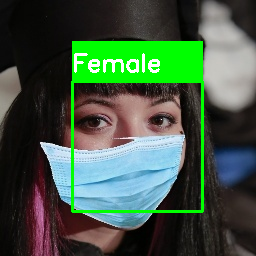

1/1 [==============================] - 0s 37ms/step


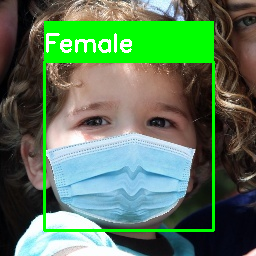

1/1 [==============================] - 0s 28ms/step


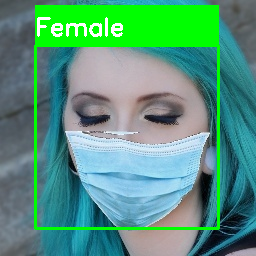

1/1 [==============================] - 0s 25ms/step


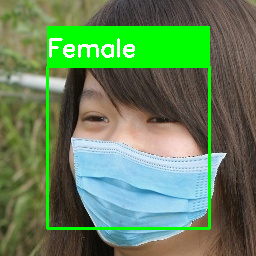

1/1 [==============================] - 0s 22ms/step


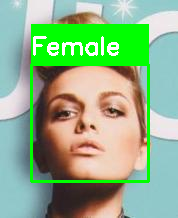

1/1 [==============================] - 0s 21ms/step


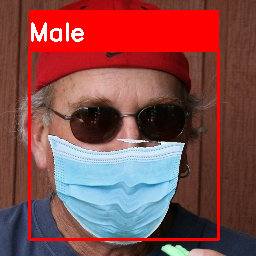

1/1 [==============================] - 0s 22ms/step


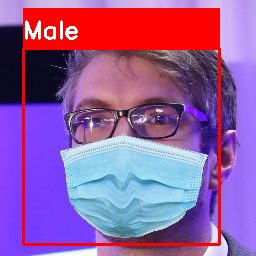

1/1 [==============================] - 0s 23ms/step


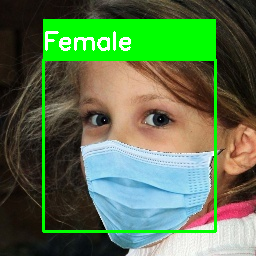

1/1 [==============================] - 0s 30ms/step


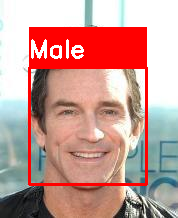

1/1 [==============================] - 0s 27ms/step


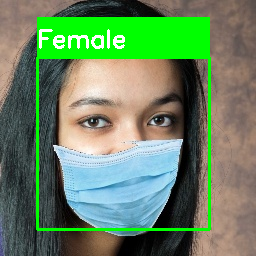

1/1 [==============================] - 0s 23ms/step


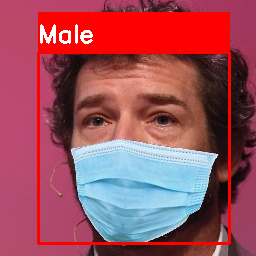

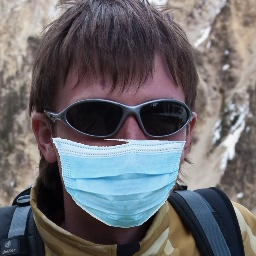

1/1 [==============================] - 0s 21ms/step


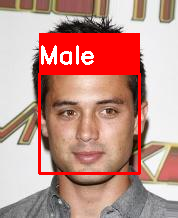

1/1 [==============================] - 0s 22ms/step


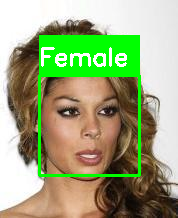

1/1 [==============================] - 0s 21ms/step


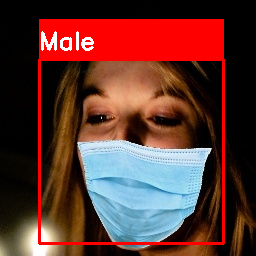

1/1 [==============================] - 0s 20ms/step


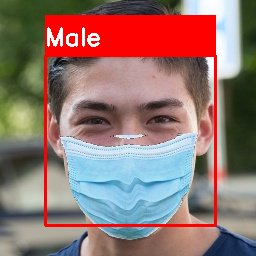

1/1 [==============================] - 0s 37ms/step


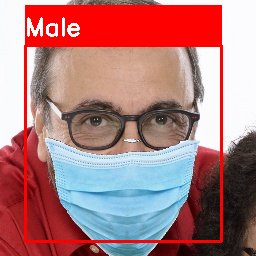

1/1 [==============================] - 0s 25ms/step


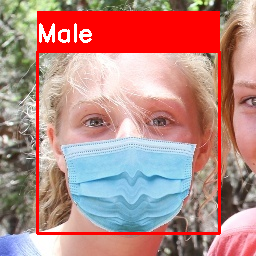

In [34]:
zip_filename = 'testing (1).zip'
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('testing1')


parent_test = 'testing1'
main_test = os.path.join(parent_test, 'test')

for filename in os.listdir(main_test):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(main_test, filename)
        gender_detection(image_path)
cv2.destroyAllWindows()

You can also capture your own photo and check the model

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 25ms/step


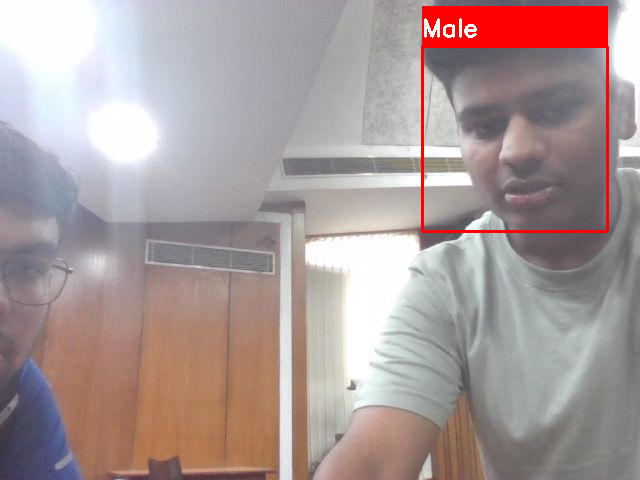

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()

  gender_detection(filename)
except Exception as err:

  print(str(err))